In [1]:
import numpy as np
from matplotlib import pyplot as plt
from src.FireFramework import * # importieren des Frameworks
from PIL import Image

## Karteneinlesung

In [3]:
def loadImage(path, cropsection, size):
    img_ = Image.open(path).convert('RGB').crop(cropsection).resize(size, Image.NEAREST) # Rezisemethode nicht ändern
    img = np.array(img_)
    img_.close()
    return img

def loadFuelmap(path, cropsection, size):
# Erzeugt Fuelmap aus Kartenmaterial der ESA
# path: Pfad zum Kartenmaterial
# area: Bildausschnitt (links, oben, rechts, unten)
# size: Auflösung der Fuelmap (x,y)

    # Lädt Bild & konvertiert in Array
    img = loadImage(path, cropsection, size)
    plt.imshow(img) # Optional zur Überprüfung

    # Farben des Kartenmaterials zu Brennwerten
    # HIER VERSCHIEDENE BRENNWERTE EINSETZEN & AUSPROBIEREN
    lookupfuel = {
        #Tree Cover
        (0,100,0): 0.8,
        #Shrubland
        (255,187,34): 0.6,
        #Grassland
        (255,255,76): 0.4,
        #Cropland
        (240,150,255): 0.6,
        #Built-up
        (250,0,0): 0.3,
        #Bare/sparse vegetation
        (180,180,180): 0.2,
        #Snow and Ice
        (240,240,240): 0,
        #Permanent water bodies
        (0,100,200): 0,
        #Herbaceous wetland
        (0,150,160): 0.1,
        #Mangroves
        (0,207,117): 0.1,
        #Moss and lichen
        (250,230,160): 0.1,
    }

    fuelmap = np.zeros(size)
    
    # Konvertiert Karte zu Fuelmap durch Dictionary Lookup
    for i in range(size[0]):
        for j in range(size[1]):
            fuelmap[i,j] = lookupfuel.get(tuple(img[i,j]), 0)
        if(i % (size[0]/10) == 0): print(100 * i / size[0], "%") # Ladebalken

    return fuelmap

## Modelldefinition

In [4]:
def dot(t1,t2):
    return t1[0] * t2[0] + t1[1] * t2[1]

In [5]:
# Liste der pro Zelle zu speichernden Werte
params = ["fuel", "fire", "windx", "windy", "height", "burned", "flammability"]

# Relativvektoren der zu betrachtenen Nachbarn (Kreis mit Radius #)
radius = 1

relative_neighbours = []
for x in range(radius * 2 +1):
    for y in range(radius*2 +1):
        xcord = x - radius
        ycord = y - radius
        r = xcord**2 + ycord**2
        
        if r <= radius**2 and r != 0:
            relative_neighbours.append((xcord,ycord))

In [6]:
def transition(cellState, neighbourStates, returnState):
    
    #Parameter der Nachbarn:
    slope = []
    rel_wind = []
    neighbour_fire = []
    distance = []

    #Vorbereitung der Werte der Nachbarn
    for n in neighbourStates:
        
        slope_ = np.tanh(n.getParam("height") - cellState.getParam("height"))
        fire_ = n.getParam("fire")
        distance_ = np.sqrt(dot(n.getRelativeVector(), n.getRelativeVector()))
        wind = (n.getParam("windx"), n.getParam("windy"))
        rel_wind_ = np.tanh(dot(wind, n.getRelativeVector()) / distance_)
        
        slope.append(slope_)
        neighbour_fire.append(fire_)
        distance.append(distance_)
        rel_wind.append(rel_wind_)  

    #Konvertieren zu numpy arrays
    slope = np.array(slope)
    rel_wind = np.array(rel_wind)
    neighbour_fire = np.array(neighbour_fire)
    distance = np.array(distance)

    #Wahrscheinlichkeiten berechnen

    slope_coeff = - np.sum(neighbour_fire * slope / distance)
    wind_coeff = - np.sum(neighbour_fire * rel_wind / distance)
    
    p_burn = 1/8 * np.sum(neighbour_fire / distance) + 0.1 * slope_coeff + 0.1 * wind_coeff
    p_burn *= cellState.getParam("flammability")
    
    p_stop = (1 - cellState.getParam("fuel")) ** 8  #Erlöschen bei wenig Brennwert

    
    #Wahrscheinlichkeiten umsetzen
    
    
    if p_burn >= np.random.uniform():
        returnState.setParam("fire", 1)
    
    if cellState.getParam("fire") == 1:
        if p_stop >= np.random.uniform():
            returnState.setParam("fire", 0)
            returnState.setParam("burned", 1)
    


        
    returnState.addToParam("fuel", -0.05*cellState.getParam("fire")) # Verringerung des Brennwerts
    if returnState.getParam("fuel") < 0:
        returnState.setParam("fuel", 0)
    returnState.addToParam("flammability", -0.05*cellState.getParam("fire"))
    if returnState.getParam("flammability") < 0:
        returnState.setParam("flammability", 0)

## Startwerte

In [20]:
fuelmap = loadImage("data/fuelmap1.jpg", (0,0,20,20),(20,20))
heightmap = loadImage("data/heightmap.jpg", (0,0,20,20),(20,20))

def initial_field(row, col):
    
    fuel = (1 - fuelmap[row,col,2])**4
    flammability = 1
    
    
    fire = 0
    if row == 5 and col == 5: fire = 1
        
    burned = 0

    height = heightmap[row,col,0]
    windx = 0
    windy = 0

    return [fuel, fire, windx, windy, height, burned, flammability] # Hier der Anfangswert-return

---
## Modell erzeugen

In [21]:
SIZE = 10
g = Grid(SIZE, SIZE, params, relative_neighbours, transition, initial_field)

In [22]:
def drawImage(field, index):
    plt.imshow(np.stack([field[index,:,:,1],field[index,:,:,0],np.zeros(shape = (SIZE,SIZE))], axis = 2))
    plt.show()

### Modell auswerten

In [23]:
# Läuft mehrere Iterationen durch und gibt das ganze Feld (mit zeitlicher Entwicklung) zurück.
N = 10
result = g.runModel(N)

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


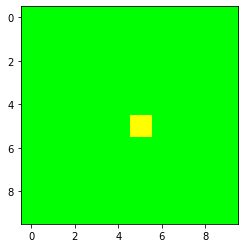

In [26]:
drawImage(result, 0)